李沐刚好有这个竞赛的[视频教程](https://www.bilibili.com/video/BV1NK4y1P7Tu?spm_id_from=333.788.videopod.episodes&vd_source=8924ad59b4f62224f165e16aa3d04f00)，跟着做一下

In [1]:
import sys
sys.path.append('./../../') #d2l here
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#不加这行 在跑d2l代码时内核可能崩溃
import hashlib
import os
import tarfile
import zipfile
import requests
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
%matplotlib inline

In [2]:
train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
print(train_data.iloc[0:4],[0,1,2,3,-3,-2,-1])

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml  

在每个样本中，第一个特征是ID，删掉。

In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据  
“这里是把训练和测试集放在一起算均值方差，因为比赛已经有测试集了，实际情况不一定能这么做”

In [5]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值，我们用一次独热编码替换它们（下面这一行的作用是什么，我需要学习一下）  
“某列有五类值，就将此列等价为五列，对应的列置1，不存在的列置0”？

In [6]:
all_features = pd.get_dummies(all_features, dummy_na = True)
all_features.shape

(2919, 330)

从`pandas`格式中提取NumPy格式，并将其转换为张量表示

In [7]:
n_train = train_data.shape[0]
all_features = all_features * 1
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)

**训练**

In [8]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

这里更关心相对误差，而不是绝对误差(以防便宜的房子对预测结果的影响小于贵的房子)。解决这个问题的一种方法是用价格预测的对数来衡量差异

In [9]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features),1 , float('inf'))
    #上一行 把`net(features)`的结果限制在1到inf,小于1的值会直接被赋值为1
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))#预测值和labels值都做log，然后算MSE 开根号
    return rmse.item()

训练函数借助Adam优化器（可以把Adam看作sgd的替代品）  
（权重衰减 是什么?）

In [10]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

**K折交叉验证**（没学过这个，需要学一下）

In [11]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

**返回训练和验证误差的平均值**

In [12]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) # 把第i折对应分开的数据集、验证集拿出来   
        net = get_net()
        # *是解码，变成前面返回的四个数据
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # 训练集、验证集丢进train函数 
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls,valid_ls],
                    xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                    legend=['train','valid'],yscale='log')
        print(f'fold{i+1},train log rmse {float(train_ls[-1]):f},'
             f'valid log rmse {float (valid_ls[-1]):f}')
    return  train_l_sum / k, valid_l_sum / k # 求和做平均

fold1,train log rmse 0.170545,valid log rmse 0.157256
fold2,train log rmse 0.162433,valid log rmse 0.192679
fold3,train log rmse 0.164248,valid log rmse 0.168599
fold4,train log rmse 0.167882,valid log rmse 0.154340
fold5,train log rmse 0.162677,valid log rmse 0.182751
5-折验证：平均训练log rmse：0.165557,平均验证log rmse：0.171125


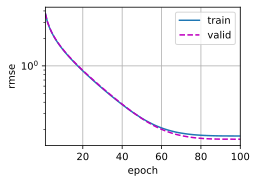

In [13]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)   
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}')   
d2l.plt.show()#这一行是我自己加的 不然不出图

train log rmse 0.162390


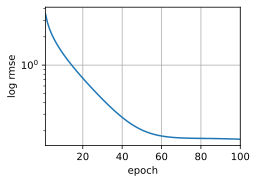

In [15]:
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)  
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
            ylabel = 'log rmse', xlim=[1,num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('submission.cvs',index = False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)
d2l.plt.show()#这一行是我自己加的 不然不出图